In [94]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.tokenize import word_tokenize
import nltk
import re
import string
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers.merge import concatenate
from keras.models import Model,Sequential
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

### Data Processing

In [2]:
stop_words = stop_words.union(set(['http','https','com','co','this','like','amp','via']))

In [3]:
train = pd.read_csv(r"C:\Users\aayus\Desktop\Kaggle\Real or Fake\train.csv")
test = pd.read_csv(r"C:\Users\aayus\Desktop\Kaggle\Real or Fake\test.csv")
submission = pd.read_csv(r"C:\Users\aayus\Desktop\Kaggle\Real or Fake\sample_submission.csv")
train = train.fillna('')

In [4]:
train['text2clean'] = train[['keyword','location','text']].apply(lambda x: ' '.join(x), axis=1)

In [5]:
train.text2clean

0         Our Deeds are the Reason of this #earthquake...
1                  Forest fire near La Ronge Sask. Canada
2         All residents asked to 'shelter in place' ar...
3         13,000 people receive #wildfires evacuation ...
4         Just got sent this photo from Ruby #Alaska a...
                              ...                        
7608      Two giant cranes holding a bridge collapse i...
7609      @aria_ahrary @TheTawniest The out of control...
7610      M1.94 [01:04 UTC]?5km S of Volcano Hawaii. h...
7611      Police investigating after an e-bike collide...
7612      The Latest: More Homes Razed by Northern Cal...
Name: text2clean, Length: 7613, dtype: object

In [62]:
def cleaning_text(text):
    lemmatizer = WordNetLemmatizer()
    lem = lambda x : lemmatizer.lemmatize(x)
    #text = text.lower()
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    x = text.split()
    text = [i for i in x if i not in stop_words]
    text = " ".join(text)
    text = re.sub('thi','',text)
    text = re.sub('co','',text)
    return text

In [63]:
train['cleanText'] = train.text2clean.apply(lambda x: cleaning_text(x))

In [64]:
train.cleanText

0        Our Deeds Reason earthquake May ALLAH Forgive us
1                   Forest fire near La Ronge Sask Canada
2       All residents asked helter place notified offi...
3       13 000 people receive wildfires evacuation ord...
4       Just got sent photo Ruby Alaska smoke wildfire...
                              ...                        
7608    Two giant cranes holding bridge llapse nearby ...
7609    aria ahrary TheTawniest The ntrol wild fires C...
7610    M1 94 01 : 04 UTC 5000m S Volcano Hawaii : zDt...
7611    Police investigating e - bike llided car Littl...
7612    The Latest : More Homes Razed Northern Califor...
Name: cleanText, Length: 7613, dtype: object

In [65]:
test = test.fillna("")

In [66]:
test['text2clean'] = test[['keyword','location','text']].apply(lambda x: ' '.join(x), axis=1)
test['cleanText'] = test.text2clean.apply(lambda x: cleaning_text(x))
test.cleanText

0                        Just happened terrible car crash
1       Heard earthquake different cities stay safe ev...
2       forest fire spot pond geese fleeing across str...
3                   Apocalypse lighting Spokane wildfires
4                  Typhoon Soudelor kills 28 China Taiwan
                              ...                        
3258    EARTHQUAKE SAFETY LOS ANGELES SAFETY FASTENERS...
3259    Storm RI worse last hurricane My city amp;3oth...
3260           Green Line derailment Chicago : UtbXLcBIuY
3261    MEG issues Hazardous Weather Outlook HWO : 3X6...
3262    CityofCalgary activated Municipal Emergency Pl...
Name: cleanText, Length: 3263, dtype: object

#### Word2Vec

In [67]:
documents = list(train.cleanText)

In [68]:
x = []
for i in documents:
    temp = word_tokenize(i)
    x.append(temp)

In [69]:
max_seq_len = 0
for i in x:
    max_seq_len = max(max_seq_len, len(i))
max_seq_len

42

In [70]:
len(documents)

7613

In [98]:
Embedding_dim = 30

In [99]:
model = Word2Vec(x,size=Embedding_dim,window=5,min_count=2,workers=10)

In [100]:
model.train(x,total_examples=len(documents),epochs=10)

(846260, 1138790)

In [101]:
words = list(model.wv.vocab)
len(words)

8889

In [102]:
max_num_words = 10000

In [103]:
model.wv.most_similar(cleaning_text("fire"))

[('careless', 0.8488051891326904),
 ('nfirmation', 0.8329757452011108),
 ('Waimate', 0.8160998821258545),
 ('alarm', 0.809814453125),
 ('mountains', 0.7955184578895569),
 ('buildings', 0.7949268817901611),
 ('forest', 0.7807135581970215),
 ('burning', 0.7679315209388733),
 ('doors', 0.760080873966217),
 ('mansion', 0.7537153959274292)]

In [104]:
model.wv.syn0.shape[1]

30

In [105]:
model.wv.syn0.shape[0]

8889

In [106]:
vocab = model.wv.syn0.shape[0]

In [107]:
model.wv.syn0

array([[-0.77332705, -2.3237214 , -1.2238541 , ...,  0.55959195,
        -1.5547366 ,  0.8917461 ],
       [-1.2188041 , -2.526844  , -2.3588743 , ...,  0.9060367 ,
        -1.5502048 ,  0.15469839],
       [ 1.2757411 ,  2.2479794 , -2.5330625 , ...,  2.9436405 ,
         0.6345275 ,  0.4000741 ],
       ...,
       [-0.01281216,  0.06941091, -0.09729736, ...,  0.18741752,
        -0.03805928,  0.12437362],
       [-0.04550786,  0.03163777, -0.10964493, ...,  0.18259053,
        -0.04811862,  0.11312833],
       [-0.02284011, -0.02736425,  0.01079487, ...,  0.10272687,
        -0.08306846,  0.11382619]], dtype=float32)

### Model Specification

In [108]:
embedding_layer = Embedding(input_dim=vocab, output_dim=Embedding_dim, weights=[model.wv.syn0], input_length=max_seq_len)

In [109]:
clf = Sequential()

In [110]:
clf.add(embedding_layer)

In [111]:
clf.add(LSTM(Embedding_dim))

In [112]:
clf.add(Dense(1,activation='relu'))   

In [113]:
clf.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [114]:
print(clf.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 42, 30)            266670    
_________________________________________________________________
lstm_3 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 31        
Total params: 274,021
Trainable params: 274,021
Non-trainable params: 0
_________________________________________________________________
None


### Training

In [115]:
tokenizer = Tokenizer(num_words=vocab)
tokenizer.fit_on_texts(train.cleanText)
sequences = tokenizer.texts_to_sequences(train.cleanText)
data = pad_sequences(sequences, max_seq_len)

In [116]:
mod = clf.fit(data,train.target,validation_split=0.2,epochs=10)

Train on 6090 samples, validate on 1523 samples
Epoch 1/10
6090/6090 [==============================] - 7s 1ms/step - loss: 0.2278 - accuracy: 0.6261 - val_loss: 0.2079 - val_accuracy: 0.6914
Epoch 2/10
6090/6090 [==============================] - 6s 1ms/step - loss: 0.1524 - accuracy: 0.7839 - val_loss: 0.1726 - val_accuracy: 0.7525
Epoch 3/10
6090/6090 [==============================] - 6s 1ms/step - loss: 0.1025 - accuracy: 0.8696 - val_loss: 0.1731 - val_accuracy: 0.7682
Epoch 4/10
6090/6090 [==============================] - 6s 1ms/step - loss: 0.0754 - accuracy: 0.9084 - val_loss: 0.1792 - val_accuracy: 0.7571
Epoch 5/10
6090/6090 [==============================] - 6s 1ms/step - loss: 0.0567 - accuracy: 0.9356 - val_loss: 0.2357 - val_accuracy: 0.6625
Epoch 6/10
6090/6090 [==============================] - 6s 1ms/step - loss: 0.0446 - accuracy: 0.9534 - val_loss: 0.2014 - val_accuracy: 0.7406
Epoch 7/10
6090/6090 [==============================] - 6s 1ms/step - loss: 0.0362 - acc

### Loss

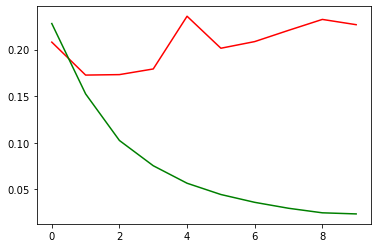

In [122]:
plt.plot(mod.history['val_loss'],c='r')
plt.plot(mod.history['loss'],c='g')
plt.show()

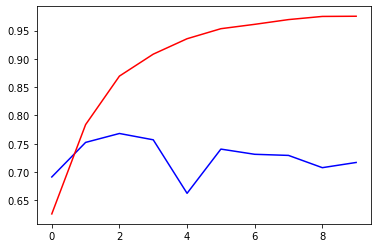

In [123]:
plt.plot(mod.history['val_accuracy'],c='b')
plt.plot(mod.history['accuracy'],c='r')
plt.show()

### Predictions

In [90]:
tokenizer2=Tokenizer(num_words=vocab)
tokenizer2.fit_on_texts(test.cleanText)
sequences2=tokenizer2.texts_to_sequences(test.cleanText)
test_data=pad_sequences(sequences2,max_seq_len)

In [91]:
preds = clf.predict(test_data)

In [92]:
preds = [0 if preds[i] >= 0.5 else 1 for i in range(len(preds))]

In [93]:
np.array(preds).shape

(3263,)

In [82]:
submission.target = preds

In [83]:
submission

,id,target
0,0,1
1,2,0
2,3,1
3,9,1
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,1
3261,10874,1


In [85]:
submission.to_csv("BasicLSTMW2V.csv",index=False)